In [1]:
import pywt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis
import math

(512, 512)


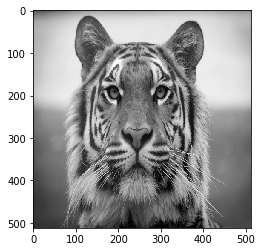

In [2]:
im = cv2.imread('08.png',0)
print(im.shape)
plt.imshow(im,cmap='gray')

# Décomposition en Ondelette

In [3]:
def histogram(array, mode='classique'):
    """Plot histogram avec normalisation par le nombre de pixel et définition de l'axe des abscisses"""
    if mode=='joli':    
        hist, bin_edges = np.histogram(array,bins=100,range=[-150,150])
    if mode == 'classique':
        hist, bin_edges = np.histogram(array,bins=100)

    plt.plot(bin_edges[1:],hist/array.size)
    plt.title(f"size of image : ({array.shape[1]},{array.shape[2]})")

## Les Paramètres

In [698]:
nb_level = 4
threshold = [0,35,85,90]#[1,15,50] # Seuil par échelle (=-1 si aucun)
bits_goal = [7,6,5,4] # nb bits par échelle
keep_level = [True,True,True,True] # liste des échelles que l'on conserve pour la reconstruction (1 si conserve 0 sinon)
keep_zeros_in_cr = True # Ne prend pas en compte les zéros dans le calcul du taux de compression

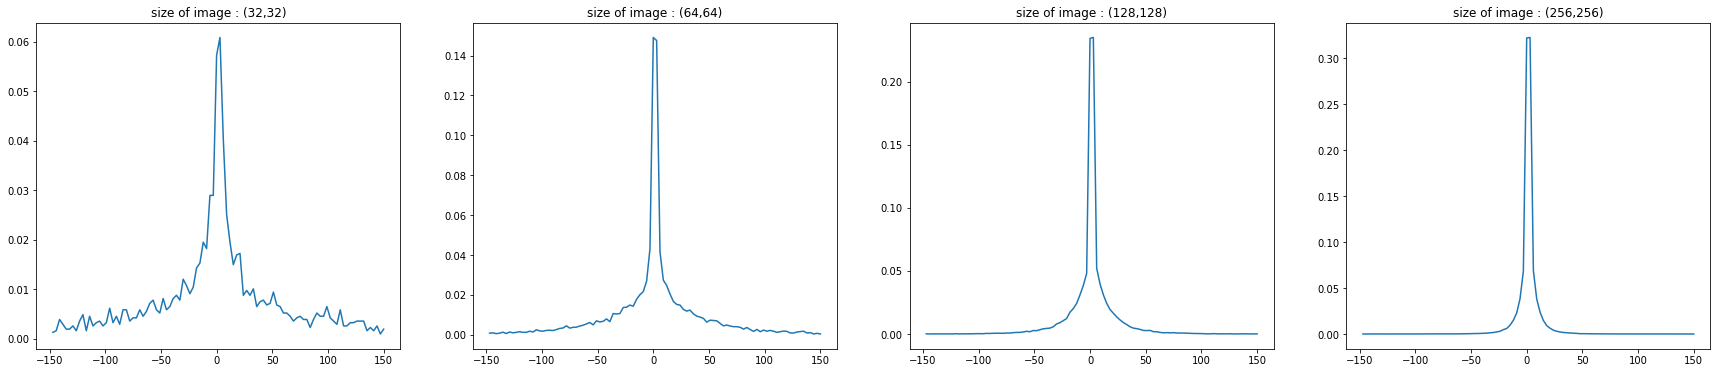

In [699]:
# compute the 2D DWT
c = pywt.wavedec2(im, 'db8',mode='periodization', level=nb_level)
arr, slices = pywt.coeffs_to_array(c)
plt.figure(figsize=(30,6))
for level in range(1,nb_level+1):
    plt.subplot(1,nb_level,level)
    histogram(np.array([c[level][0],c[level][1],c[level][2]]),'joli')

## Troncature ?

In [700]:
def filtering(array,threshold):
    return np.where((array < threshold) & (array > -threshold),0,array)

In [701]:
def troncature(array,thresholds=-1):
    if thresholds == -1:
        return array
    array_tronc = [array[0]]
    for level in range(1,nb_level+1):
        temp = []
        for detail in range(3):
            temp.append(filtering(array[level][detail],thresholds[level-1]))
        array_tronc.append(temp)
    return array_tronc

In [702]:
c_trcn = troncature(c,threshold)

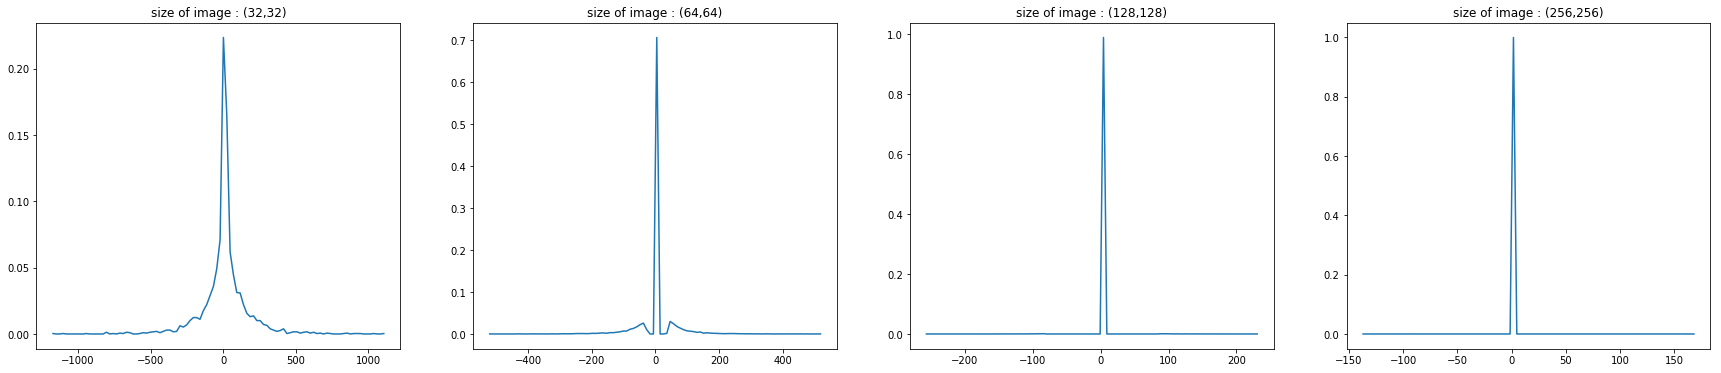

In [703]:
plt.figure(figsize=(30,6))
for level in range(1,nb_level+1):
    plt.subplot(1,nb_level,level)
    histogram(np.array([c_trcn[level][0],c_trcn[level][1],c_trcn[level][2]]))

## Quantification

In [704]:
def delta_bits(a,bits_goal,nb_level):
    """To generate the list of deltas in order to have the wanted number of bits in each level"""
    deltas = []
    for level in range(1,nb_level+1):
        temp = np.array([a[level][0],a[level][1],a[level][2]])
        val_max = 2**bits_goal[level-1]-1
        s = np.max(np.abs(temp))/val_max
        deltas.append(np.ceil(s))
    return deltas

In [705]:
def quantification(coeff,delta):
    quant = [coeff[0]]
    for level in range(1,nb_level+1):
        temp = []
        for detail in range(3):
            temp.append(np.fix(coeff[level][detail]/delta[level-1]))
        quant.append(temp)
    return quant 

In [706]:
# delta = [2**4,2**5,2**6]
delta = delta_bits(c_trcn,bits_goal,nb_level)
print(delta)
q = quantification(c_trcn,delta)

[10.0, 9.0, 9.0, 12.0]


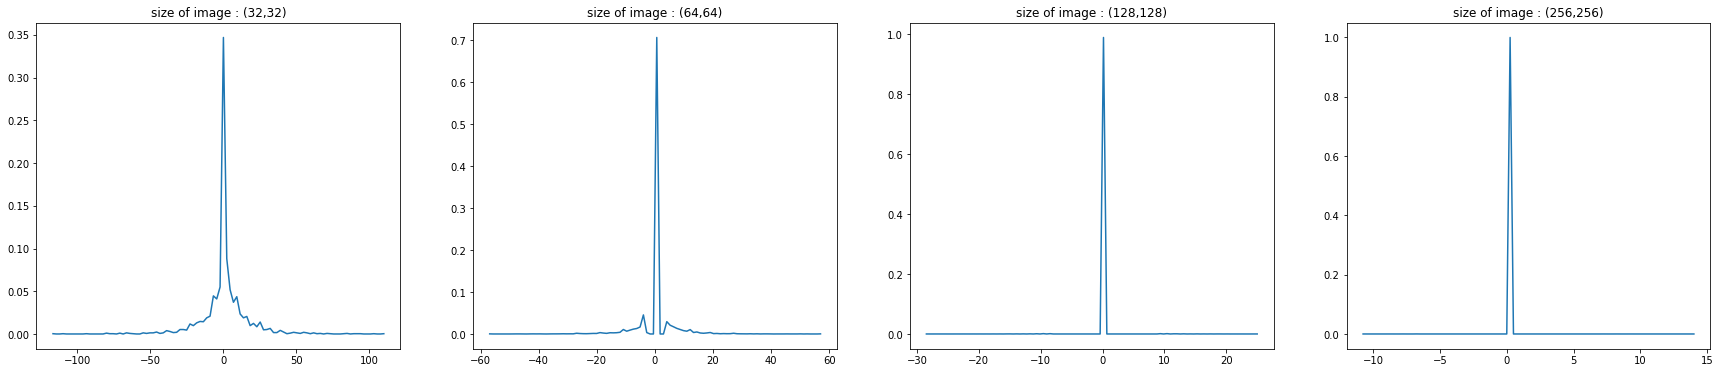

In [707]:
plt.figure(figsize=(30,6))
for level in range(1,nb_level+1):
    plt.subplot(1,nb_level,level)
    histogram(np.array([q[level][0],q[level][1],q[level][2]]))

In [708]:
def nb_bits(n):
    """pour connaitre le nombre de bits pour encoder n"""
    if n == 0:
        return 1
    n_bit = math.ceil(math.log2(n))
    if n_bit>0: return n_bit
    else : return 1

In [709]:
print(nb_bits(np.max(np.abs(q[0]))))
for level in range(1,nb_level+1):
    temp = np.array([q[level][0],q[level][1],q[level][2]])
    print(nb_bits(np.max(np.abs(temp))))

12
7
6
5
4


### Codage par Plage (avec parcours des coefficients optimisé)

In [710]:
def path_compression(array):
    """Forme un vecteur équivalent au parcours de la matrice array diagonal --> optimal pour le codage par plage"""
    ordered_array = []
    nb_diags = array.shape[0]
    for i in range(1,2*nb_diags+1):
        diag_i = np.diagonal(np.fliplr(array),nb_diags-i)
        if (i % 2) != 0:
            diag_i = [diag_i[j] for j in range(len(diag_i)-1,-1,-1)] # Reverse order
        for elements in diag_i:
            ordered_array.append(elements)
    return ordered_array

In [711]:
def run_lenght_coding(array):
    """Algorithme de Codage par plage --> return : [[value_1,indice_1],[value_2,indice_2],...]"""
    compressed_array = []
    value_temp = array[0]
    cpt = 1
    for i in range(1,len(array)):
        if array[i] == value_temp:
            cpt += 1
            if i == len(array)-1:
                if value_temp == 0: # Si des 0 à la fin --> on finit avec [0,0]
                    cpt = 0
                compressed_array.append([value_temp,cpt])
        else:
            compressed_array.append([value_temp,cpt])
            cpt = 1
        value_temp = array[i]
    return np.asarray(compressed_array).astype(int)

In [712]:
RLC_q = [q[0]]
for level in range(1,nb_level+1):
    temp = []
    for detail in range(3):
        temp.append(run_lenght_coding(path_compression(q[level][detail])))
    RLC_q.append(np.asarray(temp))

C:\Users\Anchl\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


## Reconstruction

In [713]:
r=0.375
c_rec = [q[0]]
for level in range(1,nb_level+1):
    temp = []
    for detail in range(3):
        if keep_level[level-1]: # si on conserve cette échelle
            temp.append(q[level][detail]*(1+r*np.sign(q[level][detail]))*delta[level-1])
        else: # si on supprime l'échelle
            temp.append(np.zeros(q[level][detail].shape))
    c_rec.append(temp)

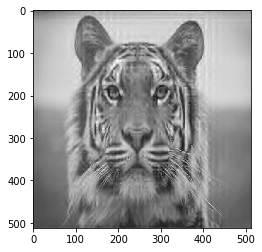

In [714]:
im_rec = pywt.waverec2(c_rec,'db8', mode='periodization')
plt.imshow(im_rec,cmap='gray')

## Mesure de l'erreur & Taux de compression

(-0.5, 511.5, 511.5, -0.5)

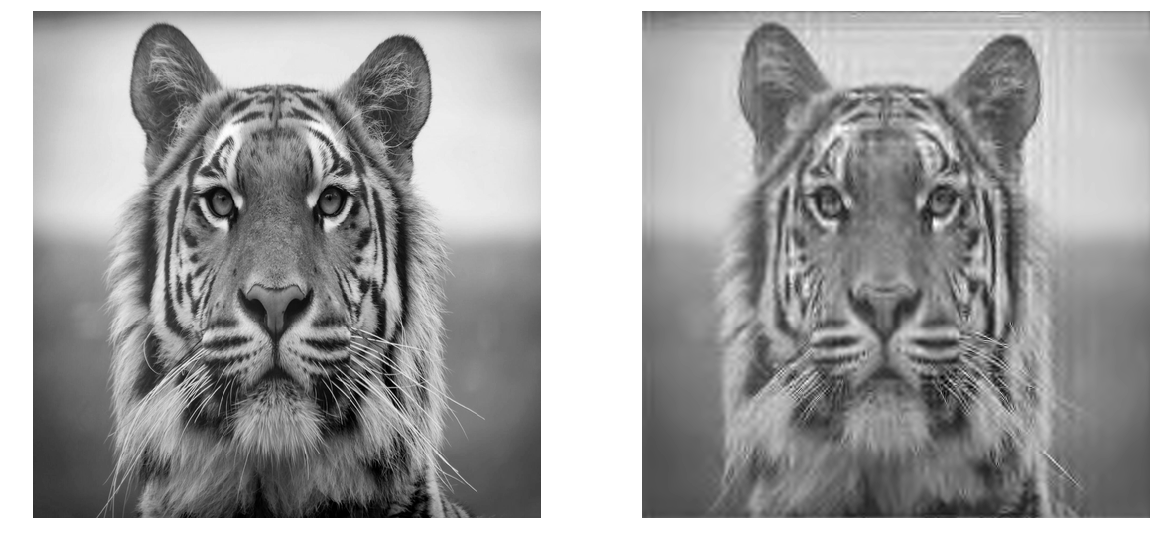

In [715]:
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.imshow(im,cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(im_rec,cmap='gray')
plt.axis('off')

In [716]:
def RMSE_error(im,im_rec):
    return np.sqrt(np.mean((im-im_rec)**2))

In [717]:
def taux_comp_classique(array_quant):
    p_ref = 8*im.size
    p_comp = array_quant[0].size*8 # Approx
    print(f"echelle {0} --> taux : {round(p_ref/p_comp)} | 0s : {np.sum(np.where(array_quant[0]==0,1,0))} | bits : {8}")
    
    for level in range(1,nb_level+1):
        temp = np.array([array_quant[level][0],array_quant[level][1],array_quant[level][2]])
        nb_bit_max = nb_bits(np.max(np.abs(temp)))
    
        if keep_level[level-1]:   # Si on conserve l'échelle
            if not keep_zeros_in_cr :
                p_comp += nb_bit_max * (temp.size - np.sum(np.where(temp==0,1,0)))
            else :
                p_comp += nb_bit_max * temp.size
            print(f"echelle {level} --> taux : {round(p_ref/p_comp)} | ratio_of_zeros : {round(np.sum(np.where(temp==0,1,0))/temp.size*100,1)} % | bits : {nb_bit_max}")
    
    return p_ref/p_comp

In [718]:
def taux_comp_rlc(RLC_coeffs):
    p_ref = 8*im.size
    p_comp = RLC_coeffs[0].size*8 # Approx
    for level in range(1,nb_level+1):
        if keep_level[level-1]:
            for detail in range(3):
                temp = RLC_coeffs[level][detail]
                val_max = np.max(temp)
                p_comp += nb_bits(val_max) * temp.size
    return p_ref/p_comp

In [719]:
print(f"RMSE Error : {RMSE_error(im_rec,im)}")
print(f"Taux de compression : {taux_comp_classique(q)}")
print(f"Avec codage par plage {taux_comp_rlc(RLC_q)}")

RMSE Error : 13.553114330953916
echelle 0 --> taux : 256 | 0s : 0 | bits : 8
echelle 1 --> taux : 71 | ratio_of_zeros : 25.6 % | bits : 7
echelle 2 --> taux : 20 | ratio_of_zeros : 70.6 % | bits : 6
echelle 3 --> taux : 6 | ratio_of_zeros : 99.0 % | bits : 5
echelle 4 --> taux : 2 | ratio_of_zeros : 100.0 % | bits : 4
Taux de compression : 1.8467087466185752
Avec codage par plage 16.067667790376955
